In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns

from adaptive_time.utils import set_directory_in_project

from importlib import reload
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

from pprint import pprint

sns.set_style("darkgrid")
sns.set_palette("colorblind")

In [3]:
from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)

In [4]:
set_directory_in_project()
data_dir = "./data"
env_names = [env_name for env_name in os.listdir(data_dir) if not env_name.startswith(".DS_Store")]
print(env_names)

Changed working directory to /Users/chanb/research/ualberta/adaptive_time
['inverted_double_pendulum-v2', 'swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'pusher-v2']


In [5]:
# prefix = "original"
# samplers_tried = dict(
#     q100=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=100),
#     q10=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=10),
#     q1=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=1),
#     q0=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=0),
#     u1=approx_integrators.UniformlySpacedIntegrator(1),
#     u10=approx_integrators.UniformlySpacedIntegrator(50),
#     u500=approx_integrators.UniformlySpacedIntegrator(500),
# )

# Uniform samplers only
prefix = "uniform"
spacings = (2 ** np.arange(1, 10, 0.5)).astype(int)
samplers_tried = {
    "u{}".format(spacing): approx_integrators.UniformlySpacedIntegrator(spacing) for spacing in spacings
}

# Adaptive samplers only
# prefix = "adaptive"
# tolerances = np.power(10, np.arange(-2.0, 4.0, 1.0)) * 5
# samplers_tried = {
#     "q{}".format(tolerance): approx_integrators.AdaptiveQuadratureIntegrator(tolerance=tolerance) for tolerance in tolerances
# }

# Compute approximate integrals using different samplers

In [6]:
def compute_approx_integrals(
    reward_file: str,
    samplers_tried: dict,
):
    print(reward_file)
    reward_sequences = np.load(reward_file).T
    idxes = np.where(reward_sequences[:, 0][:, None] - reward_sequences[:, 0][None, :] == 0)
    
    if len(idxes[0]) == len(idxes[1]):
        assert np.sum(idxes[0] - idxes[1]) == 0
    else:
        assert 0

    approx_integrals = {}
    num_pivots = {}
    for sampler_name, sampler in samplers_tried.items():
        approx_integrals[sampler_name] = []
        num_pivots[sampler_name] = []
        for idx, reward_seq in enumerate(reward_sequences):
            integral, all_pivots = sampler.integrate(reward_seq)
            approx_integrals[sampler_name].append(integral)
            num_pivots[sampler_name].append(len(all_pivots))
        approx_integrals[sampler_name] = np.array(approx_integrals[sampler_name])
        num_pivots[sampler_name] = np.array(num_pivots[sampler_name])

    return {
        "reward_file": np.array([reward_file]),
        "approx_integrals": approx_integrals,
        "num_pivots": num_pivots,
    }

In [7]:
all_results = {}

In [8]:
checkpoint = "./{}-mujoco_val_est.pkl".format(prefix)
if not os.path.isfile(checkpoint):
    for env_name in tqdm(env_names):
        if env_name in all_results:
            continue
        print("env: {}".format(env_name))

        env_dir = os.path.join(data_dir, env_name)
        all_results.setdefault(env_name, {})
        run_files = [run_file for run_file in os.listdir(env_dir) if not run_file.startswith(".DS_Store")]
        all_results[env_name] = Parallel(
            n_jobs=len(run_files)
        )(
            delayed(compute_approx_integrals)(
                os.path.join(env_dir, run_file),
                samplers_tried,
            )
            for run_file in run_files
        )
    pickle.dump(all_results, open(checkpoint, "wb"))
else:
    all_results = pickle.load(open(checkpoint, "rb"))

In [9]:
import jax

In [10]:
agg_results = {
    env_name: jax.tree_util.tree_map(
        lambda *args: np.concatenate(args),
        *all_results[env_name]
    ) for env_name in all_results
}

In [11]:
combined_checkpoint = "./{}-combined_mujoco_val_est.pkl".format(prefix)
pickle.dump(agg_results, open(combined_checkpoint, "wb"))

# Sample trajectories and estimate values

In [12]:
update_budget = 10_000_000
sample_block = 1_000_000
num_seeds = 10
estimator_checkpoint = "./{}-estimator_mujoco_val_est".format(prefix)
estimator_main_checkpoint = "{}.pkl".format(estimator_checkpoint)


has_all_files = {
    env_name: any([filename.startswith(estimator_checkpoint) and env_name in filename for filename in os.listdir(".")]) for env_name in agg_results
}
if not os.path.isfile(estimator_main_checkpoint) and not all(has_all_files.values()):
    est_results = {}
    for env_name in agg_results:
        if has_all_files[env_name]:
            continue
        print(env_name)
        vals_per_state = np.concatenate(
            [np.sum(np.load(reward_file).T, axis=-1) for reward_file in agg_results[env_name]["reward_file"]]
        )
        print(vals_per_state.shape)

        approx_integrals = agg_results[env_name]["approx_integrals"]
        num_pivots = agg_results[env_name]["num_pivots"]

        weights = np.ones(len(vals_per_state)) / len(vals_per_state)
        true_value = np.sum(weights * vals_per_state)

        est_results[env_name] = {
            "weights": weights,
            "true_value": true_value,
            "runs": []
        }

        for seed in tqdm(range(num_seeds)):
            estimated_values_by_episode = {}
            number_of_pivots_by_episode = {}
            all_values_by_episode = {}

            rng = np.random.RandomState(seed)
            start_states = rng.choice(len(vals_per_state), p=weights, size=(update_budget))

            for sampler_name, sampler in samplers_tried.items():
                # print("sampler_name:", sampler_name)
                # Update the value estimate with new samples until we run out of budget.
                used_updates = 0
                value_estimate = 0
                num_episodes = 0
                all_values_by_episode[sampler_name] = []

                estimated_values_by_episode[sampler_name] = []
                number_of_pivots_by_episode[sampler_name] = []

                # pbar = tqdm(total = update_budget)
                while used_updates < update_budget:
                    num_episodes += 1
                    if num_episodes % sample_block == 0:
                        start_states = rng.choice(len(vals_per_state), p=weights, size=(update_budget))
                    start_state = start_states[(num_episodes - 1) % sample_block]
                    val_sample = approx_integrals[sampler_name][start_state]
                    all_values_by_episode[sampler_name].append(val_sample)
                    
                    value_estimate += (1.0/num_episodes) * (val_sample - value_estimate)
                    used_updates += num_pivots[sampler_name][start_state]

                    estimated_values_by_episode[sampler_name].append(value_estimate)
                    number_of_pivots_by_episode[sampler_name].append(used_updates)
                #     pbar.update(num_pivots[sampler_name][start_state])
                # pbar.close()
            est_results[env_name]["runs"].append({
                "estimated_values_by_episode": estimated_values_by_episode,
                "number_of_pivots_by_episode": number_of_pivots_by_episode,
                "all_values_by_episode": all_values_by_episode,
            })
        # pickle.dump(est_results[env_name], open("{}-{}.pkl".format(estimator_checkpoint, env_name), "wb"))
else:
    if os.path.isfile(estimator_main_checkpoint):
        est_results = pickle.load(open(estimator_main_checkpoint, "rb"))
    else:
        est_results = {env_name: pickle.load(open("{}-{}.pkl".format(estimator_checkpoint, env_name), "rb")) for env_name in agg_results}


inverted_double_pendulum-v2
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

swimmer-v3
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

hopper-v3
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

ant-v3
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

cheetah-v3
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

pusher-v2
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

# Compile plot statistics using interpolation

In [13]:
def process_across_runs(
    runs,
    samplers_tried,
    true_value,
):
    results = {}
    for sampler in samplers_tried:
        interpolated_results = np.zeros((len(runs), update_budget + 1))
        for run_i, run in enumerate(runs):
            number_of_pivots_by_episode = run["number_of_pivots_by_episode"][sampler]
            estimated_values_by_episode = run["estimated_values_by_episode"][sampler]

            interpolated_results[run_i] = np.interp(
                np.arange(update_budget + 1),
                number_of_pivots_by_episode,
                np.abs(estimated_values_by_episode - true_value)[:number_of_pivots_by_episode[-1]]
            )
        results[sampler] = interpolated_results
    return results

In [14]:
plot_stats_checkpoint = "./{}-plot_stats_mujoco_val_est.pkl".format(prefix)

if not os.path.isfile(plot_stats_checkpoint):
    plot_stats = {}
    for env_i, env_name in enumerate(tqdm(est_results)):
        true_value = est_results[env_name]["true_value"]
        env_result = process_across_runs(
            est_results[env_name]["runs"],
            samplers_tried,
            true_value
        )
        plot_stats[env_name] = env_result
    # pickle.dump(plot_stats, open(plot_stats_checkpoint, "wb"))
else:
    plot_stats = pickle.load(open(plot_stats_checkpoint, "rb"))

  0%|          | 0/6 [00:00<?, ?it/s]

# Plot error vs number of updates

## Plot per seed result

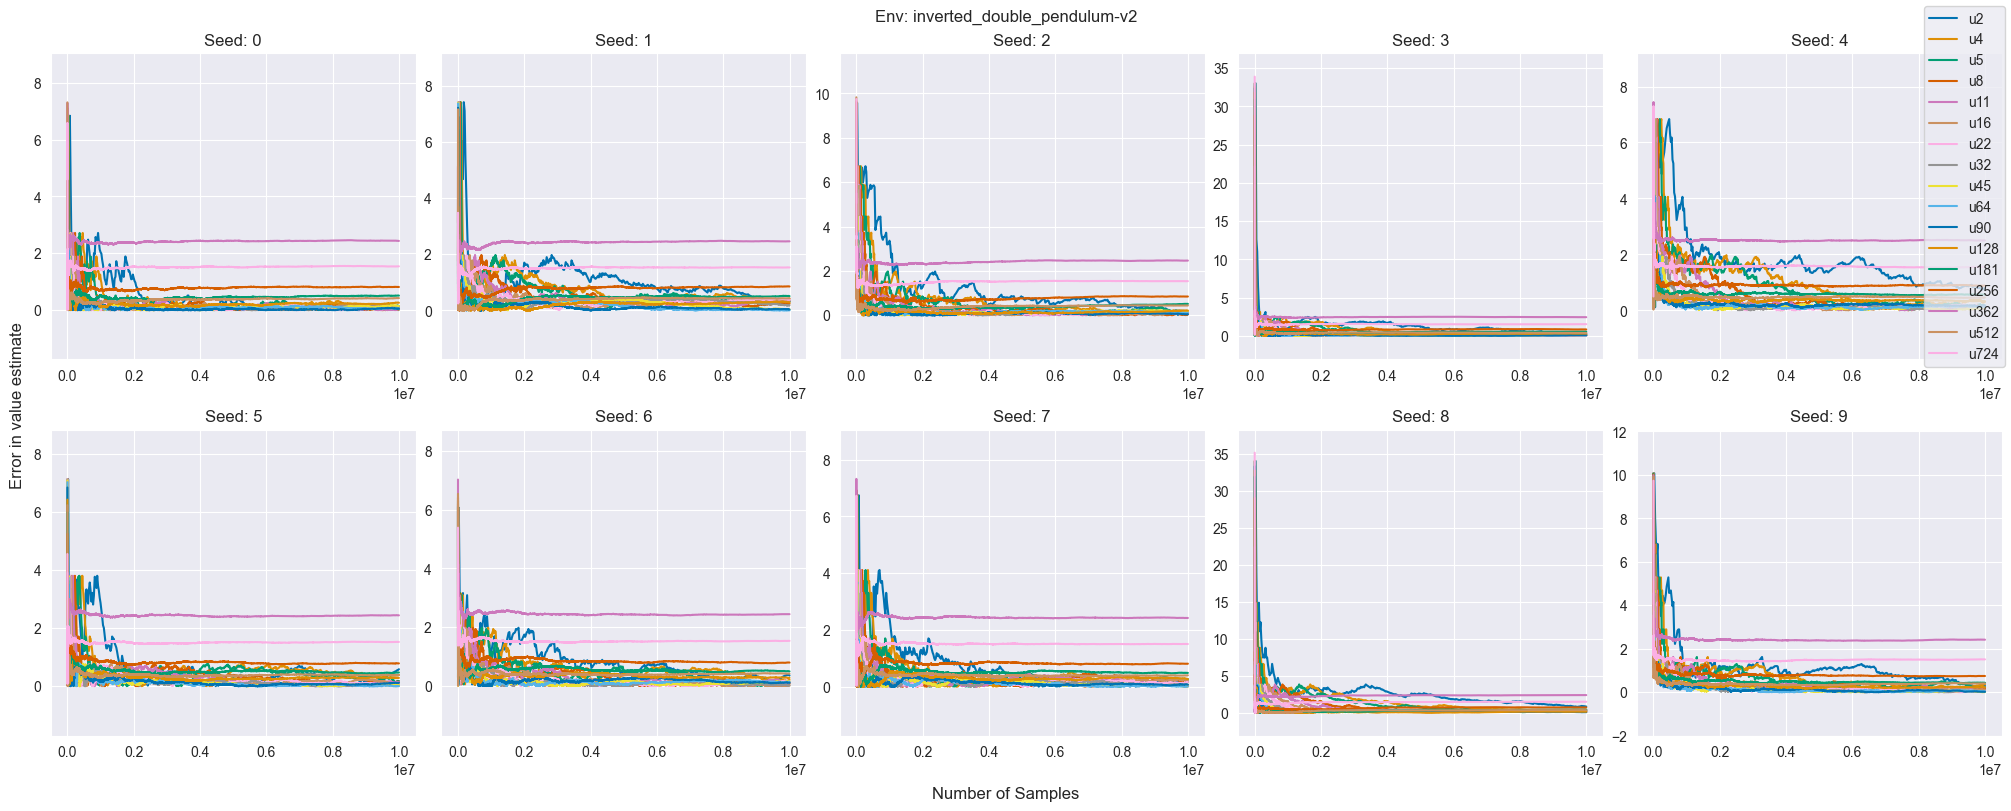

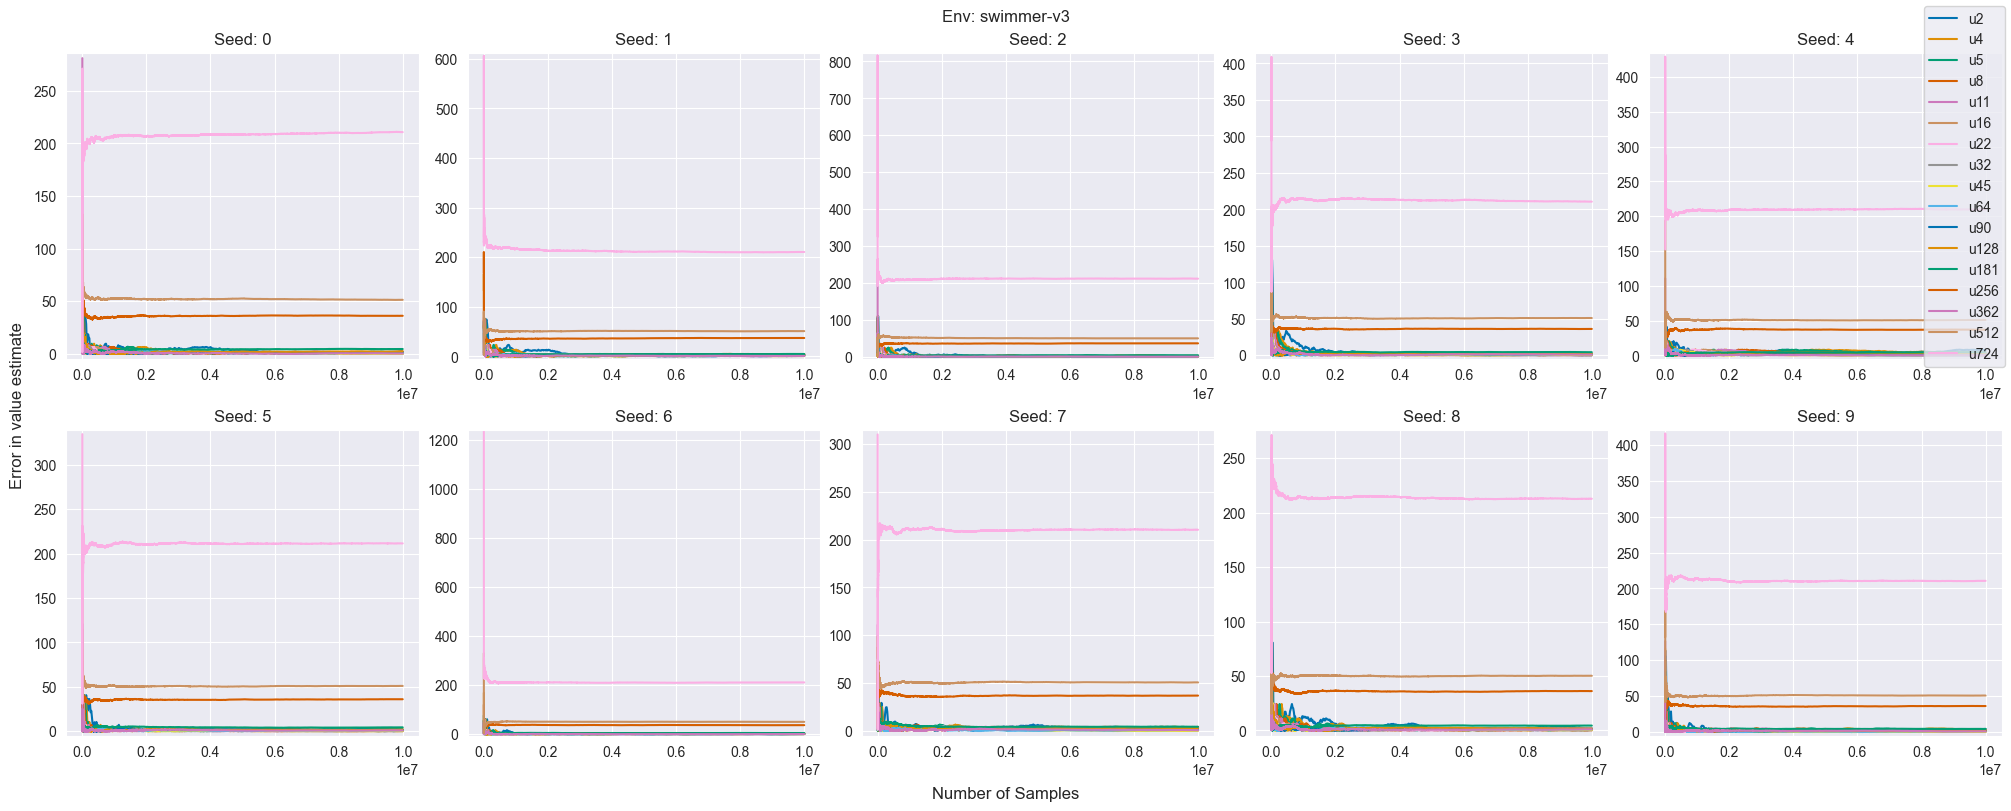

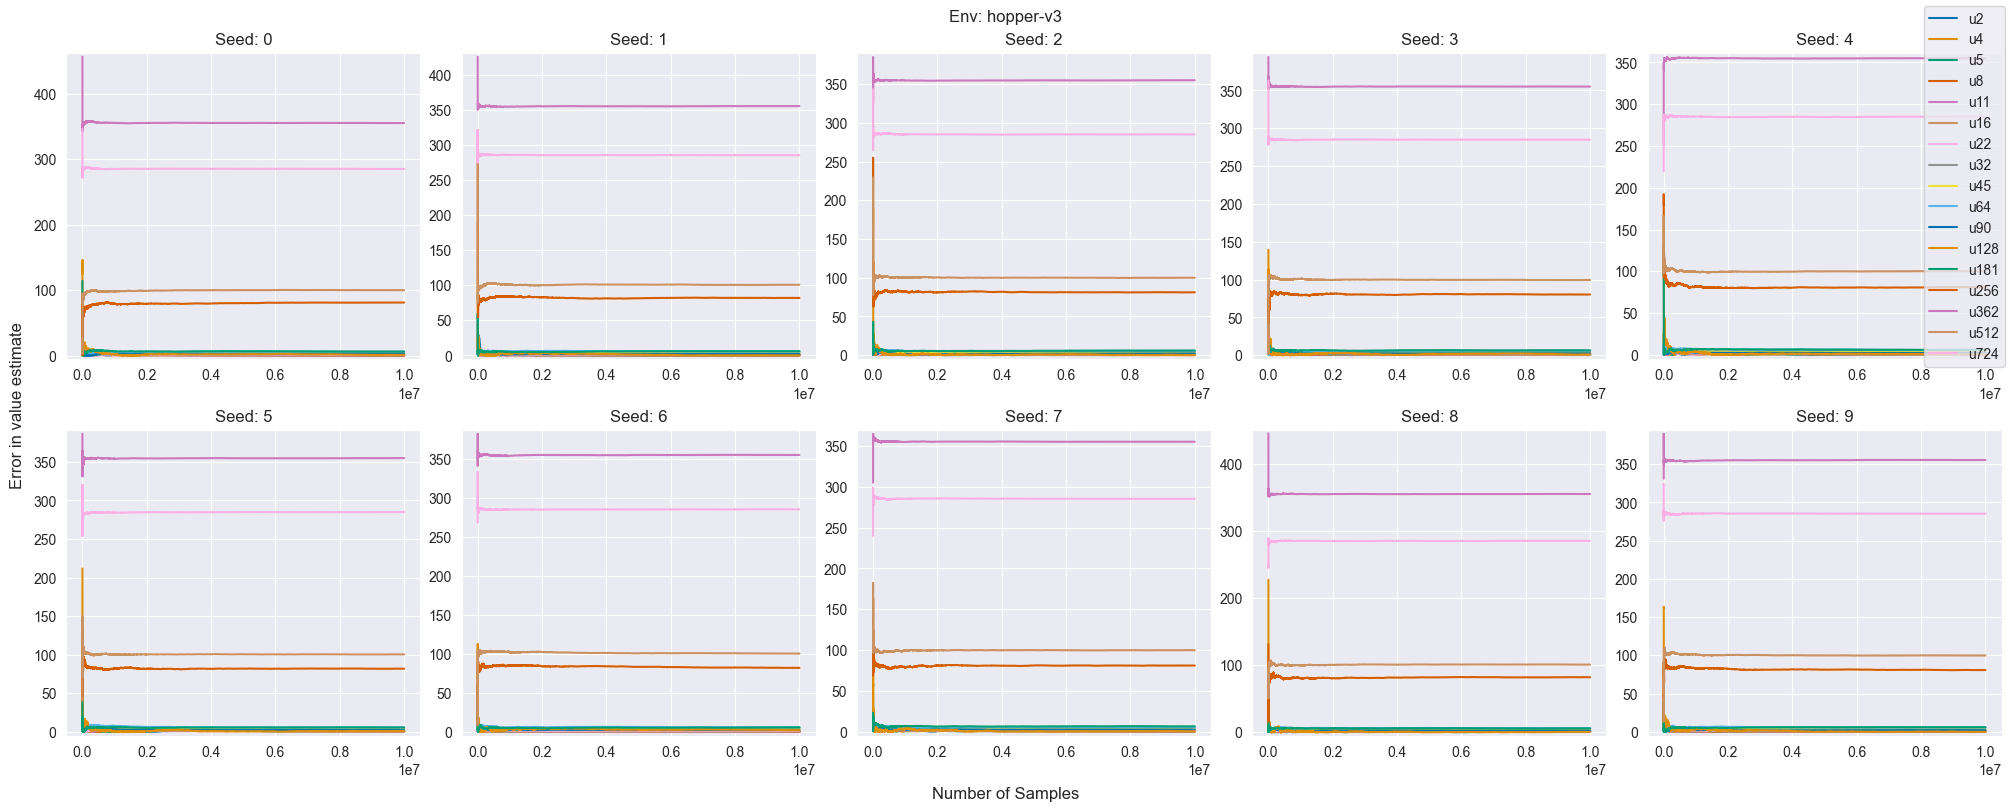

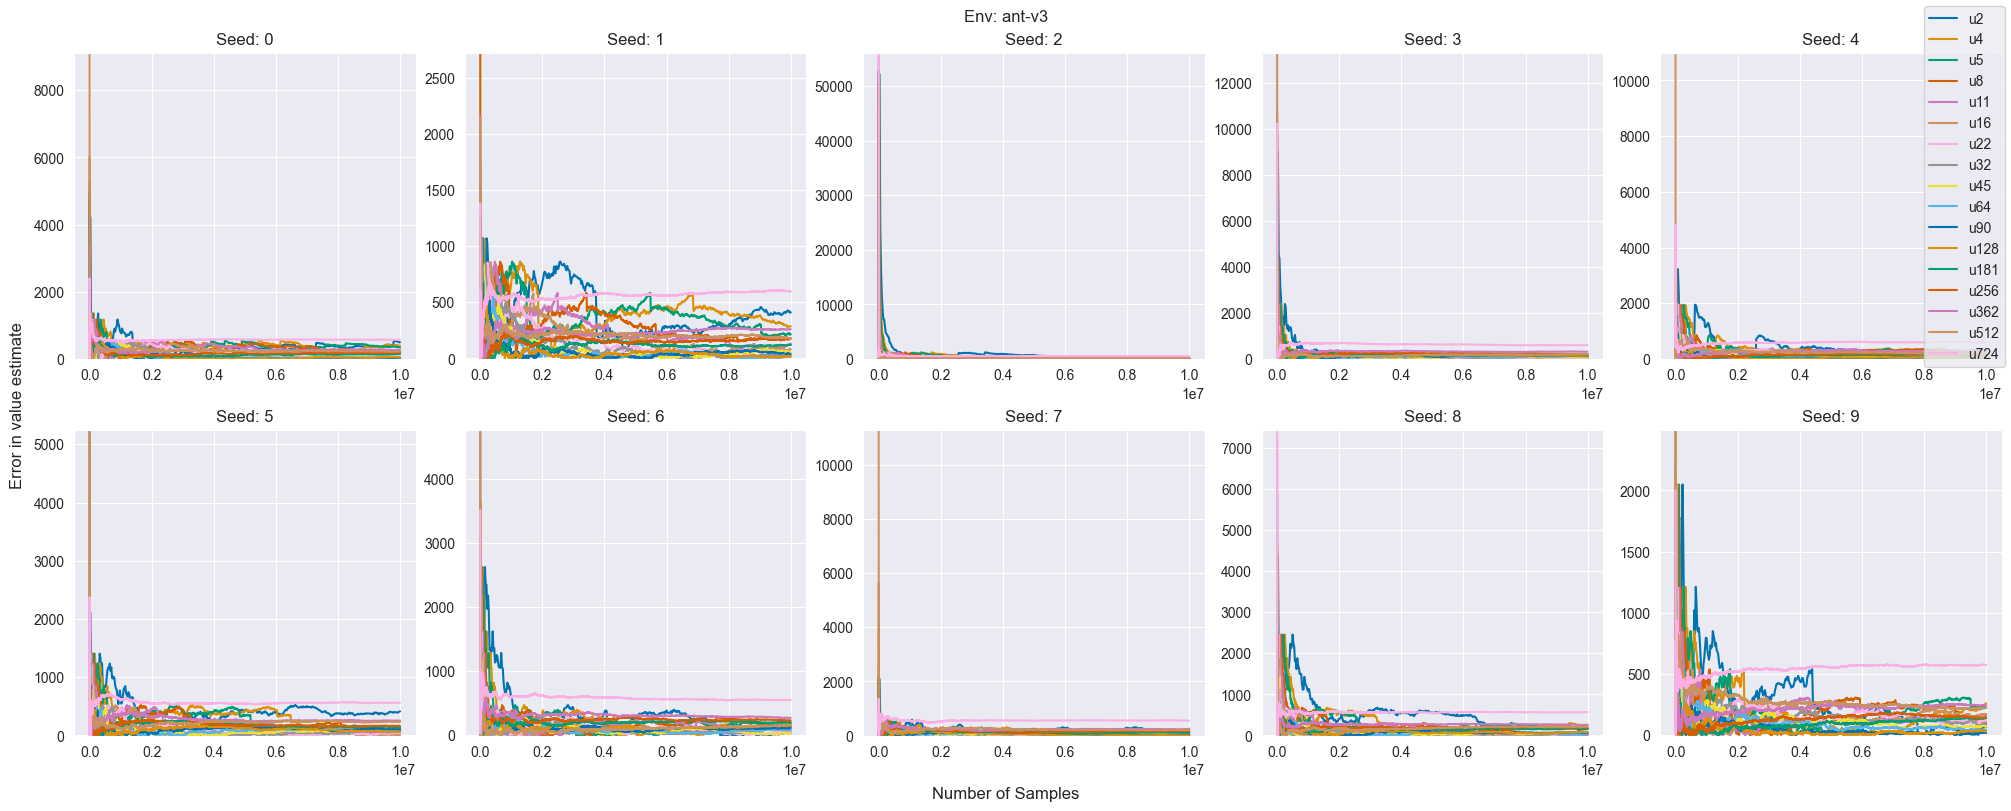

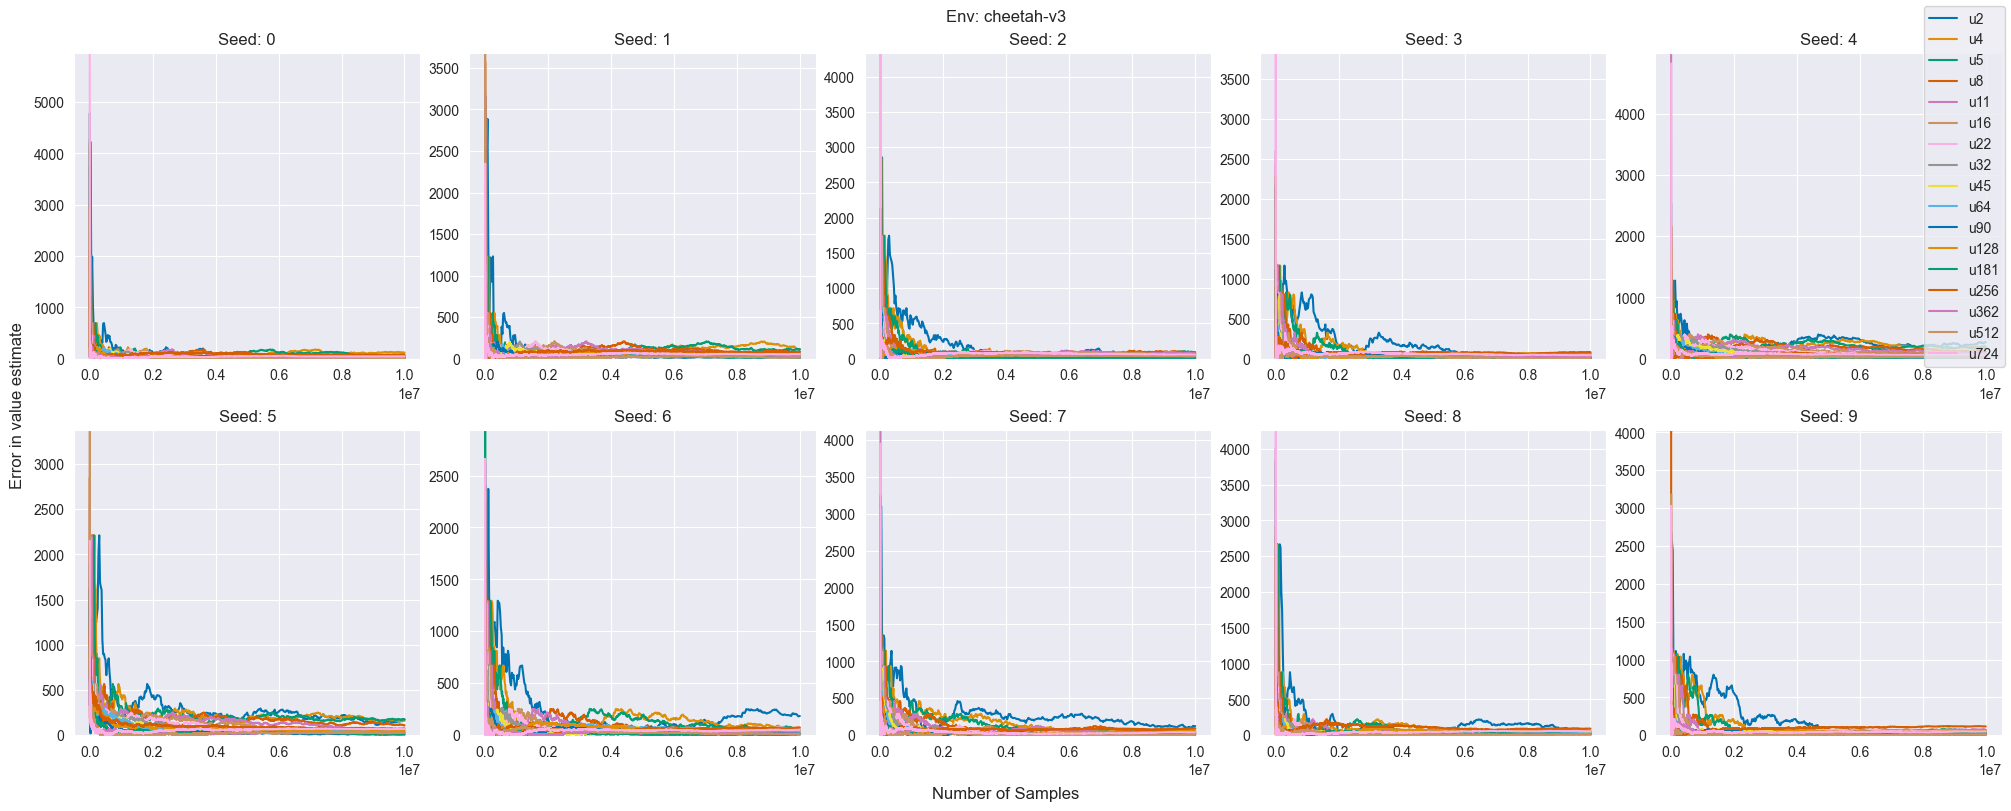

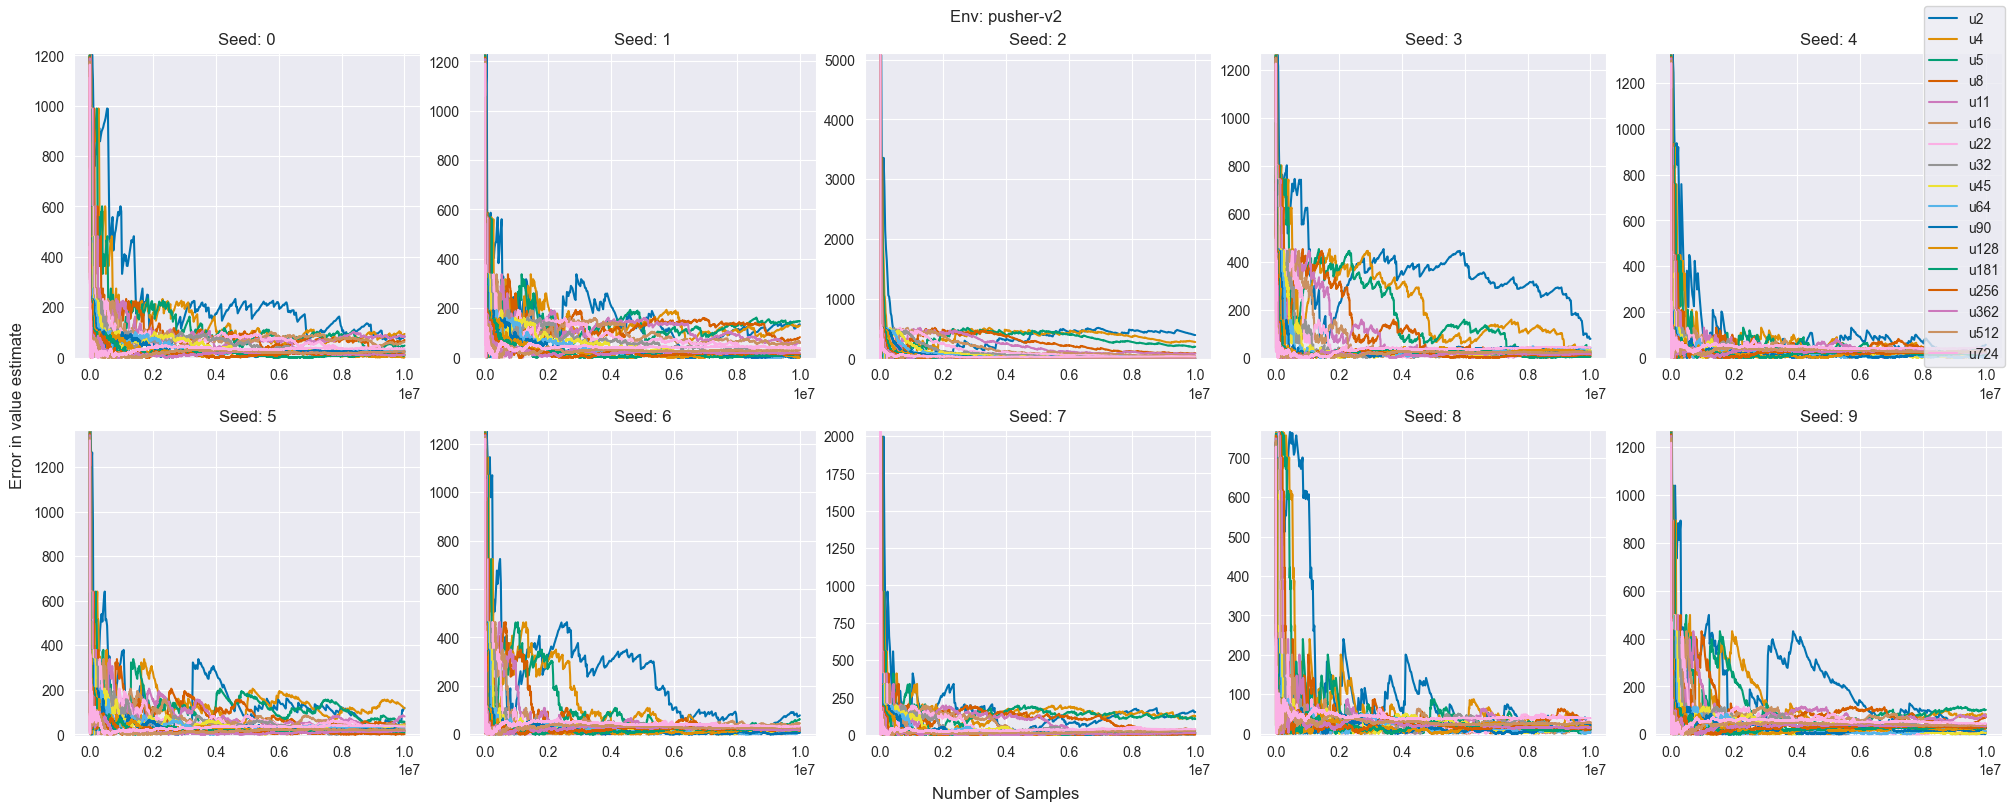

In [15]:
for env_name in est_results:
    true_value = est_results[env_name]["true_value"]

    ncols = 5
    fig, axes = plt.subplots(nrows=num_seeds // ncols, ncols=ncols, figsize=(20, 8), layout="constrained")

    for seed in range(num_seeds):
        number_of_pivots_by_episode = est_results[env_name]["runs"][seed]["number_of_pivots_by_episode"]
        estimated_values_by_episode = est_results[env_name]["runs"][seed]["estimated_values_by_episode"]
        
        ax = axes[seed // ncols, seed % ncols]
        max_diff = 0
        for s in samplers_tried.keys():
            ax.plot(
                number_of_pivots_by_episode[s],
                np.abs(estimated_values_by_episode[s]-true_value),
                label=s if seed == 0 else "")
            curr_max_diff = np.max(np.abs(estimated_values_by_episode[s]-true_value))
            if curr_max_diff > max_diff:
                max_diff = curr_max_diff

        ax.set_title("Seed: {}".format(seed))
        order = np.log10(max_diff)
        ax.set_ylim(-2 * order, max_diff + 2 * order)
    fig.supylabel("Error in value estimate")
    fig.supxlabel("Number of Samples")
    fig.legend()
    fig.suptitle("Env: {}".format(env_name))
    plt.show()

## Plot aggregated result

In [16]:
# s_to_plot = ["q1", "q10", "q100", "u1", "u10", "u500"]
# s_to_plot = ["q0", "u1"]
s_to_plot = samplers_tried.keys()

ncols = 3
fig, axes = plt.subplots(nrows=len(est_results) // ncols, ncols=ncols, figsize=(15, 8), layout="constrained")

start_idx = 0
end_idx = -1
for env_i, env_name in enumerate(est_results):
    env_result = plot_stats[env_name]
    ax = axes[env_i // ncols, env_i % ncols]
    max_val = 0
    for s in tqdm(s_to_plot):
        if s == "u1024":
            continue
        y_means = np.nanmean(env_result[s], axis=0)
        y_stderrs = np.nanstd(env_result[s], axis=0) / np.sqrt(num_seeds)

        # y_means = np.log10(y_means, out=np.zeros_like(y_means), where=(y_means != 0))
        # y_stderrs = np.log10(y_stderrs, out=np.zeros_like(y_stderrs), where=(y_stderrs != 0))

        ax.plot(
            np.arange(update_budget + 1)[start_idx:end_idx],
            y_means[start_idx:end_idx],
            label=s if env_i == 0 else ""
        )
        ax.fill_between(
            np.arange(update_budget + 1)[start_idx:end_idx],
            (y_means - y_stderrs)[start_idx:end_idx],
            (y_means + y_stderrs)[start_idx:end_idx],
            alpha=0.1
        )
        curr_max_val = np.max(y_means)
        if curr_max_val > max_val:
            max_val = curr_max_val
    ax.set_title("Env: {}".format(env_name))
    order = 1e-5
    if max_val > 0:
        order = np.log10(max_val)
    ax.set_ylim(-order, max_val + 2 * order)

fig.supylabel("Error in value estimate")
fig.supxlabel("Number of Samples")
fig.legend()
plt.show()

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

# Plot error vs hyperparameter (i.e. tolerance/discretization)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8), layout="constrained")

env_name = "ant-v3"
env_result = plot_stats[env_name]

max_val = 0

sorted_keys = sorted(float(key[1:]) for key in s_to_plot.keys())

budgets_to_check = 10 ** np.arange(5, 7, 0.5)

for budget_to_check in tqdm(budgets_to_check):
    idx = int(budget_to_check)
    y_means = []
    y_stderrs = []
    for s in sorted_keys:
        y_means.append(np.nanmean(env_result[s][:, idx]))
        y_stderrs.append(np.nanstd(env_result[s][:, idx]) / np.sqrt(num_seeds))

    ax.plot(
        sorted_keys,
        y_means,
        label=budget_to_check if env_i == 0 else ""
    )
    ax.fill_between(
        sorted_keys,
        (y_means - y_stderrs),
        (y_means + y_stderrs),
        alpha=0.1
    )
    curr_max_val = np.max(y_means)
    if curr_max_val > max_val:
        max_val = curr_max_val
    ax.set_title("Env: {}".format(env_name))
    order = 1e-5
    if max_val > 0:
        order = np.log10(max_val)

ax.set_ylim(-order, max_val + 2 * order)
fig.supylabel("Error in value estimate")
fig.supxlabel("Number of Samples")
fig.legend()
plt.show()